# Final Model Evaluation

Upon experimenting with hyperparameters to find the best ones using partial data and limited number of epochs, the final model now is ready to be evaluated

## Preparing

In [1]:
# importing needed files
from Train_evaluate import *
from modeling import *
from sigCustmized import Sig53

In [2]:
# specifying classes
selected_classes = [
        "bpsk",
        "qpsk",
        "8psk",
        "16qam",
        "64qam",
        "256qam",
        "ofdm-64",
        "ofdm-72",
        "ofdm-128",
        "ofdm-180",
        "ofdm-256",
        "ofdm-300",
        "ofdm-512",
        "ofdm-600",
        "ofdm-900",
        "ofdm-1024",
        "ofdm-1200",
        "ofdm-2048",
    ]

In [3]:
# Data reading and specifying options

root = "../../../../data/torchsig/sig18a"
train = False
impaired = True

class_list = list(Sig53._idx_to_name_dict.values())

transform = ST.Compose([
    ST.Normalize(norm=np.inf),
    ST.ComplexTo2D(),
])
target_transform = ST.DescToClassIndex(class_list=class_list)


# Instantiate the Test Dataset
test_dataset = Sig53(
    root=root,
    train=train,
    impaired=impaired,
    transform=transform,
    target_transform=target_transform,
    use_signal_data=True,
)

# Retrieve a sample and print out information to verify
idx = np.random.randint(len(test_dataset))
data, label = test_dataset[idx]
print("Dataset length: {}".format(len(test_dataset)))
print("Data shape: {}".format(data.shape))
print("Label Index: {}".format(label))
print("Label Class: {}".format(Sig53.convert_idx_to_name(label)))

test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=128,
    num_workers=8,
    shuffle=False,
    drop_last=True,
)

Dataset length: 72000
Data shape: (2, 4096)
Label Index: 10
Label Class: ofdm-256


In [4]:
# Reading metadata, contains info like SNR values .. etc

meta = Sig53(
    root=root,
    train=False,
    impaired=impaired,
    transform=None,
    target_transform=None,
)

# Retrieve a sample and print out information
idx = np.random.randint(len(meta))
data, (label, snr) = meta[idx]
print("Dataset length: {}".format(len(meta)))
print("Data shape: {}".format(data.shape))
print("Label Index: {}".format(label))
print("Label Class: {}".format(Sig53.convert_idx_to_name(label)))
print("SNR: {}".format(snr))

meta_dataloader = DataLoader(
    dataset=meta,
    batch_size=128,
    num_workers=8,
    shuffle=False,
    drop_last=True,
)

Dataset length: 72000
Data shape: (4096,)
Label Index: 4
Label Class: 64qam
SNR: 15.955159131233277


## Evaluation

In [5]:
PATH = "best_model_checkpoint.pth"
criterion = nn.CrossEntropyLoss()
device = torch.device('cuda')

model = ResNet1D(Bottleneck1D, [7,8,8,7], num_classes=len(selected_classes), in_channels=2)
model = model.to(device)

state_dict = torch.load(PATH, map_location=device)
model.load_state_dict(state_dict, strict=False)

<All keys matched successfully>

Validation Loss: 0.8757
Validation Accuracy: 65.97%
Average Inference Time per Batch: 0.2670 seconds


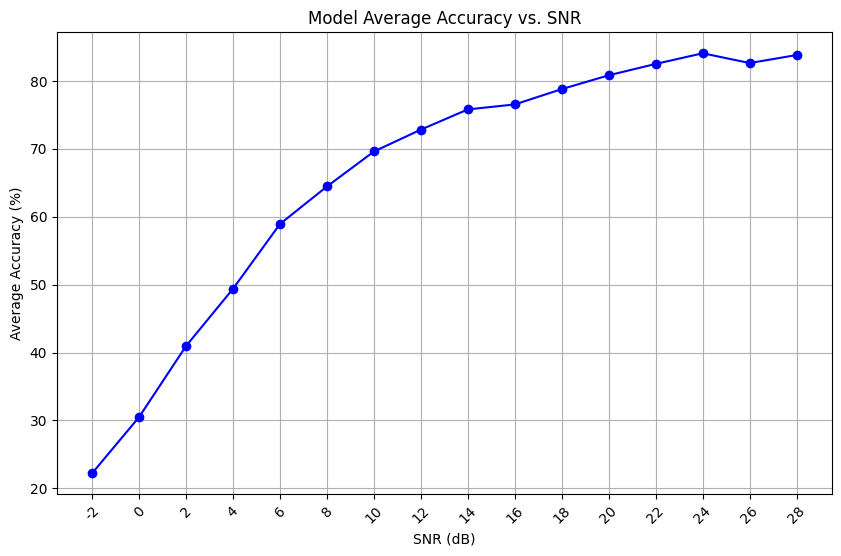

accuracy when SNR = 2.5 (+- 0.5): 40.97%
accuracy when SNR =  10 (+- 0.5): 69.62%
accuracy when SNR = 20 (+- 0.5): 80.84%
Average accuracy between SNR 2 and 20: 65.15%


<Figure size 2000x2000 with 0 Axes>

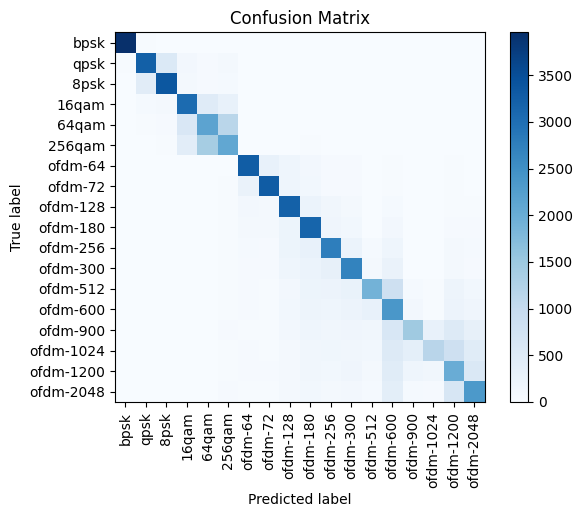

In [6]:
results = evaluate_model(model, test_dataloader,meta_dataloader, criterion,device)

labels = results['all_labels']
predictions = results['all_predictions']
plot_conf_matrix( labels, predictions,selected_classes)

In [7]:
print(results["average_accuracies"])

[22.22222222222222, 30.501392757660167, 40.971001757469246, 49.39893143365984, 58.942558746736296, 64.46428571428571, 69.61775043936731, 72.8395061728395, 75.81547064305686, 76.54867256637168, 78.80930656934306, 80.84326306141155, 82.51718213058419, 84.08319185059423, 82.64134275618375, 83.82616487455198]


## Comparison with Pretrained Models

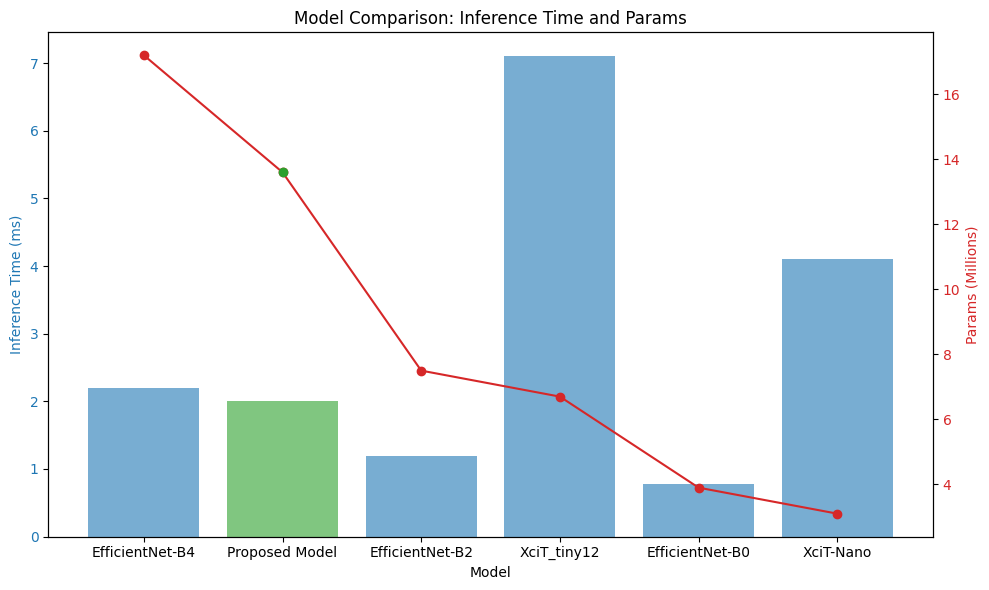

In [1]:
import matplotlib.pyplot as plt

# Data
models = ["EfficientNet-B4", "Proposed Model", "EfficientNet-B2", "XciT_tiny12", "EfficientNet-B0", "XciT-Nano"]
inference_times = [2.2, 2, 1.19, 7.1, 0.78, 4.1]
params = [17.2, 13.6, 7.5, 6.7, 3.9, 3.1]

# Highlighting the proposed model
highlight_color = 'tab:green'
default_color = 'tab:blue'

# Set up colors for the bar chart
bar_colors = [highlight_color if model == "Proposed Model" else default_color for model in models]

# Create figure and axes
fig, ax1 = plt.subplots(figsize=(10, 6))

# Bar chart for Inference Time
ax1.set_xlabel('Model')
ax1.set_ylabel('Inference Time (ms)', color=default_color)
bars = ax1.bar(models, inference_times, color=bar_colors, alpha=0.6)
ax1.tick_params(axis='y', labelcolor=default_color)

# Dual y-axis for Params
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Params (Millions)', color=color)
ax2.plot(models, params, color=color, marker='o')
ax2.tick_params(axis='y', labelcolor=color)

# Highlight the proposed model on the line plot
for i, (model, param) in enumerate(zip(models, params)):
    if model == "Proposed Model":
        ax2.plot(model, param, color=highlight_color, marker='o')

# Title and layout
plt.title('Model Comparison: Inference Time and Params')
fig.tight_layout()

# Show the plot
plt.show()


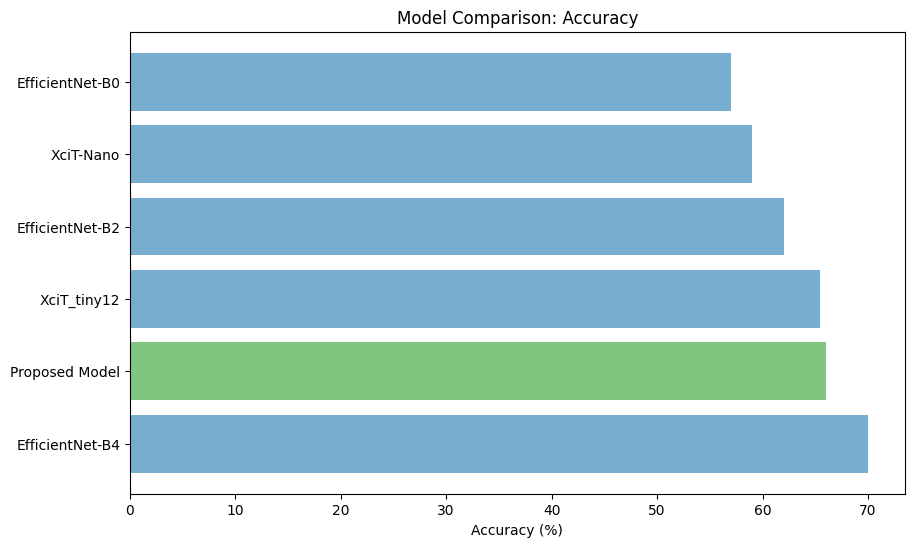

In [2]:
import matplotlib.pyplot as plt

# Data
models_accuracy = ["EfficientNet-B4","Proposed Model" ,"XciT_tiny12", "EfficientNet-B2", "XciT-Nano", "EfficientNet-B0"]
accuracies = [70, 66, 65.5, 62, 59, 57]

# Highlighting the proposed model
highlight_color = 'tab:green'
default_color = 'tab:blue'

# Set up colors for the bar chart
bar_colors = [highlight_color if model == "Proposed Model" else default_color for model in models_accuracy]

# Create the bar chart
plt.figure(figsize=(10, 6))
bars = plt.barh(models_accuracy, accuracies, color=bar_colors, alpha=0.6)
plt.xlabel('Accuracy (%)')
plt.title('Model Comparison: Accuracy')

# Highlighting the proposed model
for bar, accuracy in zip(bars, accuracies):
    if bar.get_label() == "Proposed Model":
        bar.set_color(highlight_color)

plt.show()


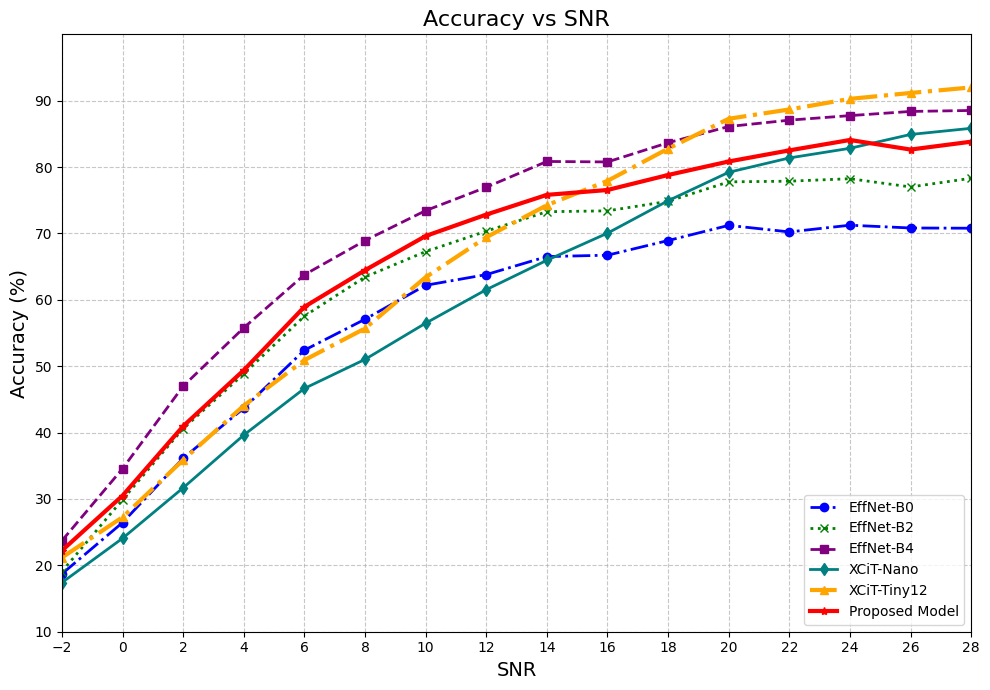

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Data
Es_N0 = np.arange(-2, 30, 2)
eff0 = [18.711111111111112, 26.439182915506034, 36.13796133567663, 43.67764915405165, 52.41514360313316, 57.075892857142854, 62.19244288224956, 63.80070546737213, 66.51910531220877, 66.72566371681415, 68.93248175182482, 71.21906507791017, 70.23195876288659, 71.24363327674024, 70.82597173144876, 70.78853046594982]
eff2 = [19.066666666666666, 29.89786443825441, 40.597539543058, 48.842386464826355, 57.550043516100956, 63.4375, 67.2671353251318, 70.34832451499118, 73.27586206896552, 73.40707964601769, 74.84032846715328, 77.77268560953254, 77.87800687285224, 78.24702886247877, 77.00971731448763, 78.31541218637993]
eff4 = [23.711111111111112, 34.563602599814296, 46.99033391915641, 55.78806767586821, 63.77284595300261, 68.92857142857143, 73.4402460456942, 76.9620811287478, 80.84808946877912, 80.77433628318585, 83.66788321167883, 86.11365719523373, 87.0704467353952, 87.7546689303905, 88.38339222614842, 88.5304659498208]
nano = [17.4, 24.071494893221914, 31.678383128295255, 39.6260017809439, 46.64926022628372, 51.026785714285715, 56.48066783831283, 61.529982363315696, 65.95992544268407, 70.04424778761062, 74.93156934306569, 79.21631530705774, 81.37886597938144, 82.83106960950764, 84.9160777385159, 85.84229390681004]
tiny = [21.177777777777777, 27.251624883936863, 35.87434094903339, 44.056099732858414, 50.91383812010444, 55.691964285714285, 63.40070298769771, 69.42239858906525, 74.25442684063374, 77.92035398230088, 82.77828467153284, 87.28230980751604, 88.68127147766323, 90.28013582342955, 91.1660777385159, 92.00268817204301]
Proposed_model = [22.22222222222222, 30.501392757660167, 40.971001757469246, 49.39893143365984, 58.942558746736296, 64.46428571428571, 69.61775043936731, 72.8395061728395, 75.81547064305686, 76.54867256637168, 78.80930656934306, 80.84326306141155, 82.51718213058419, 84.08319185059423, 82.64134275618375, 83.82616487455198]

# Plotting
plt.figure(figsize=(10, 7))
plt.plot(Es_N0, eff0, label='EffNet-B0', color='blue', linestyle='dashdot', linewidth=2, marker='o')
plt.plot(Es_N0, eff2, label='EffNet-B2', color='green', linestyle='dotted', linewidth=2, marker='x')
plt.plot(Es_N0, eff4, label='EffNet-B4', color='purple', linestyle='dashed', linewidth=2, marker='s')
plt.plot(Es_N0, nano, label='XCiT-Nano', color='teal', linestyle='solid', linewidth=2, marker='d')
plt.plot(Es_N0, tiny, label='XCiT-Tiny12', color='orange', linestyle='dashdot', linewidth=3, marker='^')
plt.plot(Es_N0, Proposed_model, label='Proposed Model', color='red', linestyle='solid', linewidth=3, marker='*')


# Customizing the chart
plt.xlabel('SNR', fontsize=14)
plt.ylabel('Accuracy (%)', fontsize=14)
plt.title('Accuracy vs SNR', fontsize=16)
plt.legend(loc='lower right')
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(np.arange(-2, 30, 2))
plt.yticks(np.arange(10, 100, 10))
plt.xlim(-2, 28)
plt.ylim(10, 100)
plt.tight_layout()

# Show the plot
plt.show()


s